                                                    Auteur: Enfifakh Khaoula 
                                                
                                                Controle continu: Machine Learning
                
                                                          Master : MMSD



**les principe etapes necessaires sont :**

1.   Collecte des données
2.   Exploration des données
3.   Préparation des données
4.   Construction des modèles
5.   Évaluation des modèles







1. Importation des bibliothèques nécessaires


In [1]:
# Importation des bibliothèques nécessaires pour le projet
import numpy as np  # Importation de la bibliothèque numpy pour les opérations avec des tableaux numériques
import matplotlib.pyplot as plt  # Importation de matplotlib pour la visualisation des données
# Configuration du style de visualisation "fivethirtyeight"
plt.style.use('fivethirtyeight')  # Appliquer le style "fivethirtyeight" pour les graphiques

import pandas as pd  # Importation de pandas pour le traitement et l'analyse des données tabulaires
from sklearn.preprocessing import MinMaxScaler  # Importation du MinMaxScaler pour normaliser les données et les ramenent dans une plage définie

# Importation des outils pour construire des modèles de réseaux de neurones avec Keras
from keras.models import Sequential  # Importation de Sequential pour créer un modèle séquentiel couche par couche
from keras.layers import Dense, LSTM, Dropout # Importation de différents types de couches de réseaux de neurones
# Une couche qui aide à prévenir le surapprentissage en éliminant aléatoirement des neurones durant l'entraînement.
# LSTM : Long Short-Term Memory, une couche récurrente utilisée pour traiter des séquences.
from keras.optimizers import Adam
import math  # Importation de la bibliothèque math pour des opérations mathématiques de base
from sklearn.metrics import mean_squared_error  # Importation de la métrique d'erreur quadratique moyenne pour évaluer les performances des modèles


2024-06-29 11:59:13.581873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2. Définition des fonctions utilitaires


In [2]:
# Fonction pour tracer les résultats réels et prédits sur un graphique
def plot_predictions(test, predicted):
    # Tracer la série de données de test (valeurs réelles) en rouge
    plt.plot(test, color='red', label='Real Apple Stock Price')
    # Tracer les prédictions (valeurs prédites) en bleu
    plt.plot(predicted, color='blue', label='Predicted Apple Stock Price')
    # Ajouter un titre au graphique
    plt.title('Apple Stock Price Prediction')
    # Ajouter des étiquettes aux axes X et Y
    plt.xlabel('Time')  # L'axe des X représente le temps
    plt.ylabel('Apple Stock Price')  # L'axe des Y représente le prix de l'action IBM
    # Ajouter une légende pour expliquer les couleurs des lignes
    plt.legend()
    # Afficher le graphique
    plt.show()  # Afficher le graphique généré

# Fonction pour calculer le root mean squared error (RMSE)
def return_rmse(test, predicted): 
    # RMSE (Root Mean Squared Error) est une mesure statistique utilisée pour évaluer les différences 
    # entre des valeurs observées (réelles) et des valeurs prédites par un modèle
    # Calcul du RMSE en prenant la racine carrée de l'erreur quadratique moyenne
    rmse = math.sqrt(mean_squared_error(test, predicted))
    # Affichage du RMSE avec un message explicatif
    print("The root mean squared error is {}.".format(rmse))

3. Chargement et préparation des données


In [3]:
# First, we get the data
dataset = pd.read_csv('AAPL.xls', index_col='Date', parse_dates=['Date'])
dataset.head()
print(len(dataset))
# Utilise la colonne "Date" comme index du DataFrame
# Interprète la colonne "Date" comme des dates


1259


In [4]:
# Vérification des valeurs manquantes
training_set = dataset[:'2016'].iloc[:, 0:1].values  # Extraction des données d'entraînement (High)
# le training_set ne contient que les prix les plus élevés atteints chaque jour.
test_set = dataset['2017':].iloc[:, 0:1].values  # Extraction des données de test

4. Visualisation des données


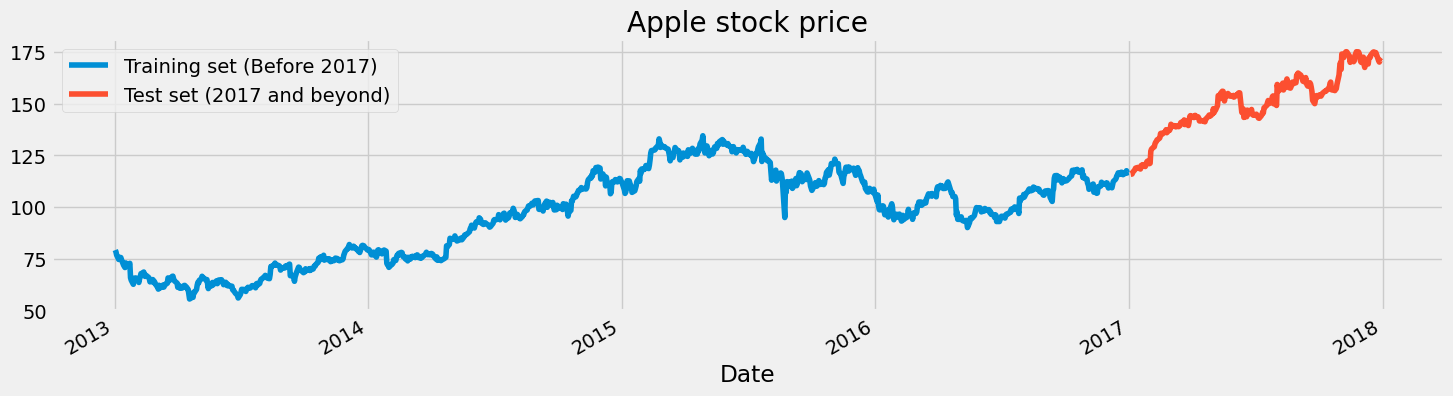

In [5]:
# Nous avons choisi l'attribut 'Open' pour les prix. Voyons à quoi cela ressemble
# Tracer les prix 'Open' pour l'ensemble d'entraînement (jusqu'à 2016)
dataset["Open"][:'2016'].plot(figsize=(16,4), legend=True)  # Créer un graphique avec taille personnalisée
# Tracer les prix 'Open' pour l'ensemble de test (à partir de 2017)
dataset["Open"]['2017':].plot(figsize=(16,4), legend=True)  # Même taille de graphique pour cohérence
# 16x4 pouces

# Ajouter une légende pour identifier les deux ensembles
plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
# Ajouter un titre au graphique
plt.title('Apple stock price')  # Indiquer que le graphique montre les prix des actions IBM
# Afficher le graphique
plt.show()  # Afficher le graphique avec les ensembles d'entraînement et de test

5. Mise à l'échelle des données


In [6]:
# Mise à l'échelle du jeu d'entraînement
sc = MinMaxScaler(feature_range=(0,1))  # Créer un scaler avec une échelle de 0 à 1
training_set_scaled = sc.fit_transform(training_set)  # Ajuster le scaler et transformer les données
training_set_scaled  # Montrer les données mises à l'échelle


array([[0.29977402],
       [0.28903746],
       [0.26931763],
       ...,
       [0.78566641],
       [0.77212823],
       [0.77465879]])

6. Création de la structure de données d'entraînement


In [7]:
# Initialisation des listes pour les données d'entraînement (X_train) et les valeurs cibles (y_train).
X_train, y_train = [], []

for i in range(12, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i, 0])

In [8]:
# Redimensionnement de X_train pour le modèle LSTM
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # Redimensionner en 3 dimensions
print(X_train.shape[0], X_train.shape[1], 1)
# Si X_train n'a pas cette structure, le modèle LSTM ne pourra pas traiter les données correctement.

996 12 1


7. Création et compilation du modèle LSTM et Entraînement du modèle



In [9]:
# Créer le modèle séquentiel
regressor = Sequential()  # Utilise le modèle séquentiel pour ajouter des couches successives.

# Première couche LSTM avec régularisation Dropout
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# Dropout aide à éviter le surapprentissage en désactivant une partie des neurones pendant l'entraînement.
regressor.add(Dropout(0.2))  # Dropout avec un taux de 20%

# Deuxième couche LSTM avec Dropout
regressor.add(LSTM(units=50, return_sequences=True))  # Conserve la séquence pour la prochaine couche LSTM
regressor.add(Dropout(0.2))  # Dropout de 20%

# Troisième couche LSTM avec Dropout
regressor.add(LSTM(units=50, return_sequences=True))  # Ajoute une autre couche LSTM
regressor.add(Dropout(0.2))  # Dropout de 20%

# Quatrième couche LSTM
regressor.add(LSTM(units=50))  # Ne retourne pas de séquences car c'est la dernière couche LSTM
regressor.add(Dropout(0.2))  # Dropout de 20%

# La couche de sortie
regressor.add(Dense(units=1))  # La sortie est une seule valeur prédite
adam = Adam(learning_rate=0.001)
# Compilation du RNN avec l'optimiseur RMSprop et la fonction de perte Mean Squared Error (MSE)
regressor.compile(optimizer=adam, loss='mean_squared_error')  # Compilation du modèle
# regressor.compile(optimizer='rmsprop', loss='mean_squared_error')  # Compilation du modèle

regressor.fit(X_train, y_train, epochs=100, batch_size=32)  # Entraînement du modèle
# taille de lot : le nombre d'échantillons traités à la fois pendant l'entraînement.

/Users/mac/Applications/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 0.1526
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0114
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0073
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0059
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0069
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0054
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0057
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0053
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0049
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0060
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0051
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0051
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0049
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0052
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - lo

In [10]:
# Rassembler le jeu de données complet à partir du jeu d'entraînement et du jeu de test
dataset_total = pd.concat((dataset["Open"][:'2016'], dataset["Open"]['2017':]), axis=0)
# Obtenir les valeurs à partir de la fin du jeu de données complet pour créer des séquences d'entrée
inputs = dataset_total[len(dataset_total) - len(test_set) - 12:].values
# Reshape le tableau d'entrée pour avoir la bonne forme
inputs = inputs.reshape(-1, 1)
# Appliquer la mise à l'échelle MinMaxScaler
inputs = sc.transform(inputs)
inputs



array([[0.75428824],
       [0.75859004],
       [0.77238133],
       [0.76390417],
       [0.77579747],
       [0.77655668],
       [0.77086299],
       [0.76124706],
       [0.7730139 ],
       [0.78566641],
       [0.77212823],
       [0.77465879],
       [0.76390417],
       [0.76453673],
       [0.76542241],
       [0.77630358],
       [0.79110699],
       [0.80148204],
       [0.80110248],
       [0.80312693],
       [0.80578394],
       [0.79604145],
       [0.81704466],
       [0.80945318],
       [0.82273825],
       [0.81704466],
       [0.81135107],
       [0.82235869],
       [0.83817432],
       [0.84412101],
       [0.82881149],
       [0.83159507],
       [0.90599177],
       [0.91801171],
       [0.92218697],
       [0.93256211],
       [0.950402  ],
       [0.96065069],
       [0.96444629],
       [0.97469499],
       [0.98253948],
       [0.98747394],
       [1.01341162],
       [1.01530942],
       [1.00809759],
       [1.0223948 ],
       [1.02492526],
       [1.036

8. Préparation des données de test et Prédiction 

In [11]:

# Préparation des données de test (X_test) à partir des inputs mis à l'échelle
X_test = []
# Génération de séquences de 60 timesteps pour chaque entrée de test
for i in range(12, len(inputs)):  # Utiliser len(inputs) pour obtenir le nombre correct d'échantillons
    X_test.append(inputs[i - 12:i, 0])  # Ajoute les 12 éléments précédents à chaque séquence de test

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Prédire les prix des actions avec le modèle LSTM formé
predicted_stock_price = regressor.predict(X_test)

# Inverser la mise à l'échelle pour ramener les prédictions à leurs valeurs d'origine
predicted_stock_price = sc.inverse_transform(predicted_stock_price)



8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step


9. Visualisation des résultats


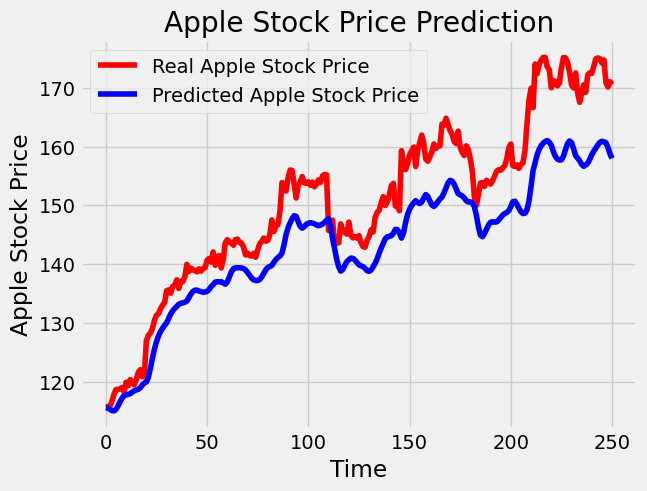

In [12]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)